In [132]:
!pip install ftfy regex tqdm

In [133]:
!pip install CLIP

In [180]:
import torch
from CLIP import clip 
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)




In [196]:
persian_cat = preprocess(Image.open("image_fusion/persian.jpeg")).unsqueeze(0).to(device)
tabby_cat = preprocess(Image.open("image_fusion/tabby-cat.jpg")).unsqueeze(0).to(device)
daisy = preprocess(Image.open("image_fusion/daisy.jpg")).unsqueeze(0).to(device)
#text = clip.tokenize(["a diagram", "a dog", "a cat"]).to(device)

In [197]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [212]:
daisy_image_embedding = model.encode_image(daisy)

In [213]:
daisy_image_embedding.size()

torch.Size([1, 512])

In [214]:
daisy.size()

torch.Size([1, 3, 224, 224])

In [225]:
import numpy as np
import matplotlib.pyplot as plt

In [226]:
def softmax(x, axis=-1):
    exp_x = np.exp(x - np.max(x, axis=axis, keepdims=True))
    return exp_x / np.sum(exp_x, axis=axis, keepdims=True)

In [227]:
def create_tokens(embeddings, num_tokens=16):
    # Reshape (1, 512) to (16, 32)
    return embeddings.reshape(num_tokens, -1)

In [228]:
tokens = create_tokens(daisy_image_embedding)

In [229]:
def self_attention(features, d_k):
    N, D = features.shape
    
    # Create query, key, and value matrices
    W_q = np.random.randn(D, d_k)
    W_k = np.random.randn(D, d_k)
    W_v = np.random.randn(D, d_k)
    
    Q = np.dot(features, W_q)
    K = np.dot(features, W_k)
    V = np.dot(features, W_v)
    
    # Compute attention scores
    attention_scores = np.dot(Q, K.T) / np.sqrt(d_k)
    attention_weights = softmax(attention_scores, axis=-1)
    
    # Compute weighted sum
    output = np.dot(attention_weights, V)
    
    return output, attention_weights

In [230]:
def multi_head_attention(features, num_heads, d_k):
    N, D = features.shape
    d_head = D // num_heads
    
    # Split features into multiple heads
    heads = []
    for i in range(num_heads):
        head_features = features[:, i*d_head:(i+1)*d_head]
        head_output, _ = self_attention(head_features, d_k)
        heads.append(head_output)
    
    # Concatenate heads
    concatenated = np.concatenate(heads, axis=-1)
    
    # Apply linear transformation
    W_o = np.random.randn(D, D)
    output = np.dot(concatenated, W_o)
    
    return output

In [231]:
def visualize_attention(attention_weights):
    plt.figure(figsize=(8, 6))
    plt.imshow(attention_weights, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title('Attention Weights')
    plt.show()

In [233]:
self_attention_output, attention_weights = self_attention(tokens.cpu().detach().numpy(), d_k=8)

In [234]:
multi_head_output = multi_head_attention(tokens.cpu().detach().numpy(), num_heads=4, d_k=8)

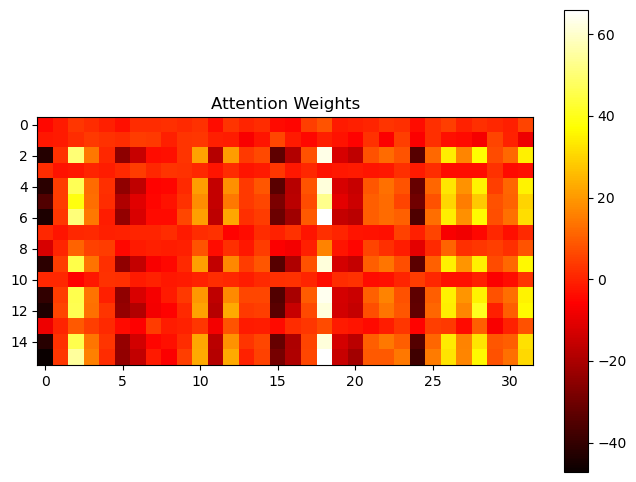

In [240]:
visualize_attention(multi_head_output)

In [241]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def visualize_token_importance(image_path, attention_weights):
    # Load and resize original image
    original_image = Image.open(image_path).convert('RGB')
    original_image = original_image.resize((224, 224))
    
    # Compute token importance
    token_importance = attention_weights.mean(axis=0)
    
    # Create a heatmap of the same size as the image
    num_tokens = len(token_importance)
    heatmap_size = int(np.ceil(np.sqrt(num_tokens)))
    heatmap = np.zeros((heatmap_size, heatmap_size))
    
    for i in range(num_tokens):
        row = i // heatmap_size
        col = i % heatmap_size
        heatmap[row, col] = token_importance[i]
    
    # Normalize heatmap
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
    
    # Upsample heatmap to match image size
    heatmap = Image.fromarray(heatmap).resize((224, 224), Image.BICUBIC)
    heatmap = np.array(heatmap)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    # Display original image
    ax1.imshow(original_image)
    ax1.set_title('Original Image')
    ax1.axis('off')
    
    # Display heatmap overlaid on original image
    ax2.imshow(original_image)
    im = ax2.imshow(heatmap, cmap='hot', alpha=0.5)
    ax2.set_title('Token Importance Heatmap')
    ax2.axis('off')
    
    # Add colorbar
    plt.colorbar(im, ax=ax2, label='Token Importance')
    
    plt.tight_layout()
    plt.show()


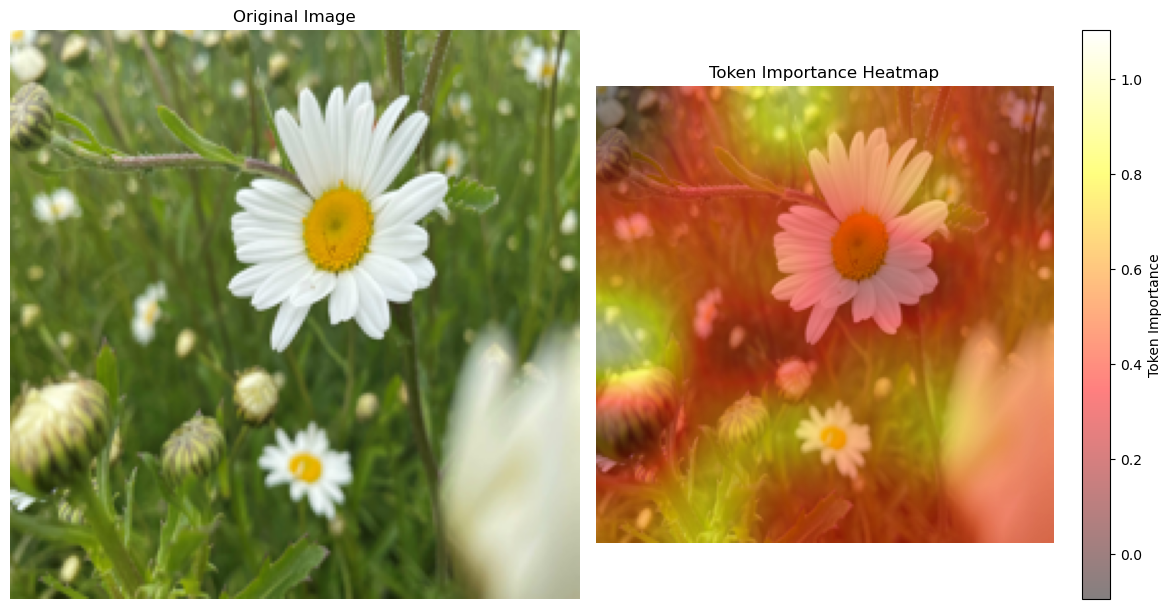

In [242]:
visualize_token_importance("image_fusion/daisy.jpg", multi_head_output)

In [243]:
def apply_attention_mask(image, attention_weights):
    # Resize attention weights to match image size
    attention_mask = Image.fromarray(attention_weights).resize(image.size, Image.BICUBIC)
    attention_mask = np.array(attention_mask)
    
    # Normalize attention mask
    attention_mask = (attention_mask - attention_mask.min()) / (attention_mask.max() - attention_mask.min())
    
    # Apply mask to image
    masked_image = np.array(image) * attention_mask[:,:,np.newaxis]
    return Image.fromarray(masked_image.astype(np.uint8))

def visualize_attention_effect(image_path, attention_weights, model):
    original_image = Image.open(image_path).convert('RGB')
    masked_image = apply_attention_mask(original_image, attention_weights)
    
    # Get CLIP embeddings for both images
    original_embedding = model.encode_image(preprocess(original_image).unsqueeze(0).to(device)).cpu().detach().numpy()
    masked_embedding = model.encode_image(preprocess(masked_image).unsqueeze(0).to(device)).cpu().detach().numpy()
    
    # Compute cosine similarity
    similarity = np.dot(original_embedding, masked_embedding.T) / (np.linalg.norm(original_embedding) * np.linalg.norm(masked_embedding))
    
    # Visualize
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.imshow(original_image)
    ax1.set_title('Original Image')
    ax1.axis('off')
    ax2.imshow(masked_image)
    ax2.set_title(f'Attention-Masked Image\nSimilarity: {similarity[0][0]:.4f}')
    ax2.axis('off')
    plt.tight_layout()
    plt.show()



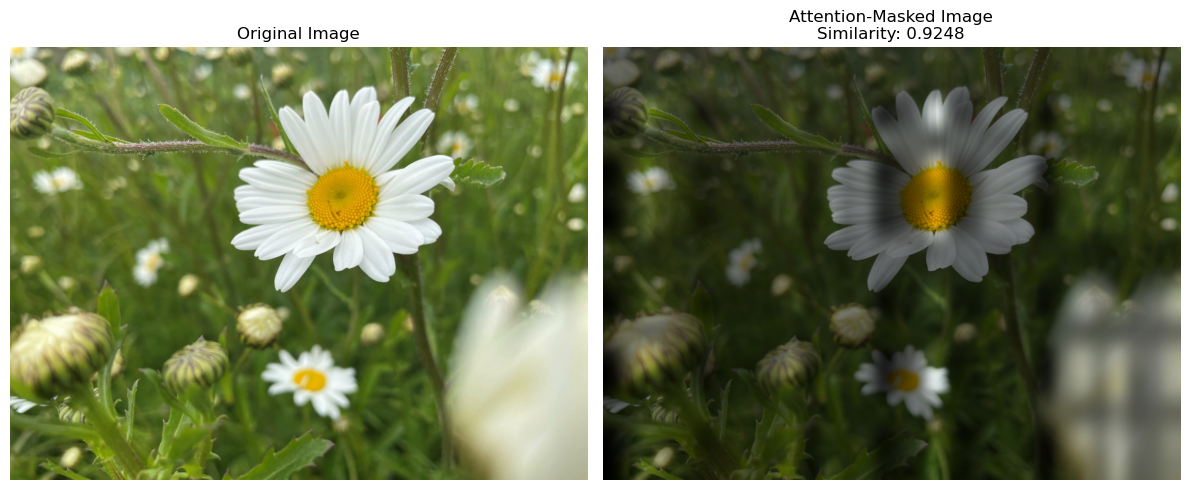

In [244]:
visualize_attention_effect("image_fusion/daisy.jpg", multi_head_output, model)